In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import tensorflow 
from tensorflow.keras.applications import mobilenet, inception_v3, inception_resnet_v2, resnet50,vgg16
from tensorflow.keras.callbacks import CSVLogger, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from keras.utils import np_utils

In [ ]:
!unzip '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/dataset/dataset.zip'

Streaming output truncated to the last 5000 lines.
  inflating: train/JUICE/JUICE0178.png  
  inflating: train/JUICE/JUICE0179.png  
  inflating: train/JUICE/JUICE0180.png  
  inflating: train/JUICE/JUICE0181.png  
  inflating: train/JUICE/JUICE0182.png  
  inflating: train/JUICE/JUICE0183.png  
  inflating: train/JUICE/JUICE0184.png  
  inflating: train/JUICE/JUICE0185.png  
  inflating: train/JUICE/JUICE0186.png  
  inflating: train/JUICE/JUICE0187.png  
  inflating: train/JUICE/JUICE0188.png  
  inflating: train/JUICE/JUICE0189.png  
  inflating: train/JUICE/JUICE0190.png  
  inflating: train/JUICE/JUICE0191.png  
  inflating: train/JUICE/JUICE0192.png  
  inflating: train/JUICE/JUICE0193.png  
  inflating: train/JUICE/JUICE0194.png  
  inflating: train/JUICE/JUICE0195.png  
  inflating: train/JUICE/JUICE0196.png  
  inflating: train/JUICE/JUICE0197.png  
  inflating: train/JUICE/JUICE0198.png  
  inflating: train/JUICE/JUICE0199.png  
  inflating: train/JUICE/JUICE0200.png  
  infl

In [ ]:
img_height = 224
img_width = 224
n_classes = 25

# specify location of freiburg groceries dataset, along with train and val folders

model_name = 'MobileNet'
dataset_name = 'Freiburg Groceries'

root_dir = "/content"
train_dir = "/train"
val_dir = "/val"
test_dir = "/test"


#hyperparameters tuning

In [ ]:
# base network
base_id = 1 # 0 = Inception-v3, 1 = MobileNet, 2 = Inception-ResNet-v2, 3 = ResNet50

# network hyperparameters
n_epochs = 100
n_batches = 32
learning_rate = 0.001
dr = 0.5
wd = 0.0001


# save parameters
date_dir = '2021-10-12' # specify save directory for results using YYYY-MM-DD format
n_rounding = 4
#parameter_type = ' ' # specify parameter (learning_rate, dr, wd) that is being evaluated

In [ ]:
enable_model_save = True
weight_decay_test = True
dropout_test = False
learning_rate_test = False
use_previous_weights = False

In [ ]:
def create_dense_model(input_shape,weight_decay, r_dropout):

    input_layer = Input(shape=input_shape)

    top = GlobalAveragePooling2D()(input_layer)
    top = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc_1')(top)

    predictions = Dense(units=n_classes, activation='softmax', kernel_regularizer=l2(l=weight_decay), name='softmax')(top)

    model_combined = Model(inputs=input_layer, outputs=predictions)

    if use_previous_weights is True:
        print("Loading previous weights")
        model_combined.load_weights(filepath='/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model1.h5', by_name=True) # set path to saved weights here

    return model_combined

In [ ]:
# generate file names for csv and weight files
def save_filenames(base_network_name, test_descriptor, param, precision):

    descriptor = '/' + base_network_name + '_' + test_descriptor + '='

    name_csv = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/results/' + date_dir + descriptor + str(round(param, precision)) + '.csv'
    name_weights = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/' + date_dir + descriptor + str(round(param, precision)) + '.h5'

    return name_csv, name_weights

# Preprare Training and Validation Data

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, rotation_range=10, horizontal_flip=True)
datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=root_dir+train_dir,target_size=(224,224),
                                                        batch_size=n_batches,shuffle=False)

val_generator = datagen_val_test.flow_from_directory(directory=root_dir+val_dir, target_size=(224, 224),
                                                         batch_size=n_batches, shuffle=False)


Found 7000 images belonging to 25 classes.
Found 1500 images belonging to 25 classes.


In [ ]:

# find y_train/y_val/y_test
y_train = train_generator.classes
y_val = val_generator.classes


    # convert output to one-hot encoding
y_train = np_utils.to_categorical(y=y_train,num_classes=n_classes)
y_val = np_utils.to_categorical(y=y_val, num_classes=n_classes)
n_train = y_train.shape[0]
n_val = y_val.shape[0]



In [ ]:

    # base network = Inception-v3
if base_id is 0:
  base = inception_v3.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (5,5,2048)
  base_name = 'Inception_v3'

    # base network = MobileNet
elif base_id is 1:
  base = mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,1024)
  base_name = 'MobileNet'

    # base network = Inception-ResNet-v2
elif base_id is 2:
  base = inception_resnet_v2.InceptionResNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (5,5,1536)
  base_name = 'Inception_ResNet_v2'

    # base network = ResNet50
else:
  base = resnet50.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (1,1,2048)
  base_name = 'ResNet50'






17235968/17225924 [==============================] - 1s 0us/step


In [ ]:

    # generate features
x_train_features = base.predict(train_generator, steps=n_train/n_batches, verbose=1)
x_val_features = base.predict(val_generator, steps=n_val/n_batches, verbose=1)


    # correct y_train / y_val / y-test lengths
l_train = x_train_features.shape[0]
l_val = x_val_features.shape[0]
y_train = y_train[0:l_train]
y_val = y_val[0:l_val]


 

46/46 [==============================] - 5s 100ms/step


In [ ]:
   # display hyperparameter summary
print("Dataset Summary:")
print ("\tX-Train: "+str(x_train_features.shape[0]))
print ("\tX-Validation: "+str(x_val_features.shape[0]))
print ("\tY-Train: "+str(y_train.shape[0]))
print ("\tY-Validation: "+str(y_val.shape[0]))



Dataset Summary:
	X-Train: 7000
	X-Validation: 1500
	Y-Train: 7000
	Y-Validation: 1500


In [ ]:
    # display hyperparameter summary
print("Hyperparameter Summary:")
print ("\tWeight decay: "+str(wd))
print ("\tDropout: "+str(dr))
print ("\tLearning rate: "+str(learning_rate))
print ("\t# of epochs: "+str(n_epochs))
print ("\tBatch size: "+str(n_batches))



Hyperparameter Summary:
	Weight decay: 0.0001
	Dropout: 0.5
	Learning rate: 0.001
	# of epochs: 100
	Batch size: 32


# Fine tune MobileNet

In [ ]:

    # create dense model on top of base network
model = create_dense_model(input_shape=base_output_shape, weight_decay=wd, r_dropout=dr)


    # compile model
model.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

   

In [ ]:
# create save filenames
if weight_decay_test is True:
  parameter_type = 'wd'
elif dropout_test is True:
  parameter_type = 'dr'
elif learning_rate_test is True:
  parameter_type = 'lr'

file_csv, file_trained_weights = save_filenames(base_name, parameter_type, wd, n_rounding)

In [ ]:
 # train model

csv_logger = CSVLogger(filename=file_csv, append=True, separator=',')
early_stopper = EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(x=x_train_features,
                                 y=y_train,
                                 batch_size=n_batches,
                                 epochs=n_epochs,
                                 validation_data=(x_val_features, y_val),
                                 steps_per_epoch=None,
                                 shuffle=True
                                
                                )

Epoch 1/100
219/219 [==============================] - 2s 9ms/step - loss: 0.7376 - accuracy: 0.7737 - val_loss: 0.7716 - val_accuracy: 0.7640
Epoch 2/100
219/219 [==============================] - 2s 9ms/step - loss: 0.4185 - accuracy: 0.8694 - val_loss: 0.7200 - val_accuracy: 0.7787
Epoch 3/100
219/219 [==============================] - 2s 8ms/step - loss: 0.2492 - accuracy: 0.9203 - val_loss: 0.4087 - val_accuracy: 0.8800
Epoch 4/100
219/219 [==============================] - 2s 10ms/step - loss: 0.1645 - accuracy: 0.9509 - val_loss: 0.4861 - val_accuracy: 0.8620
Epoch 5/100
219/219 [==============================] - 2s 9ms/step - loss: 0.1272 - accuracy: 0.9647 - val_loss: 0.8266 - val_accuracy: 0.8040
Epoch 6/100
219/219 [==============================] - 2s 9ms/step - loss: 0.1057 - accuracy: 0.9703 - val_loss: 0.5010 - val_accuracy: 0.8800
Epoch 7/100
219/219 [==============================] - 2s 9ms/step - loss: 0.0928 - accuracy: 0.9759 - val_loss: 0.4277 - val_accuracy: 0.906

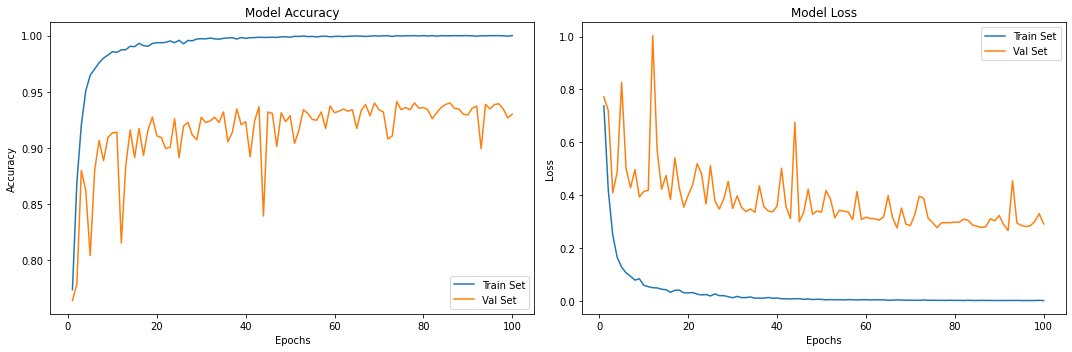

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
if enable_model_save == True:
  model.save_weights(filepath='model1.h5')

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title     A   = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
# save trained model

model.save("/content/drive/MyDrive/Multi Class Object Classification for Retail Products/Grocery-Product-Classification/saved model/Grocery classification_mobileNetv2.h5")

In [ ]:
model = load_model('/content/drive/MyDrive/Multi Class Object Classification for Retail Products/Grocery-Product-Classification/saved model/Grocery classification_mobileNetv2.h5')

# Test Model on Unseen Instances (Test Data)

In [ ]:
# create custom model with trained FC layer weights
def create_model_test(img_size,model_type,base_name):

    if model_type == 0:
        print("Creating MobileNet model")
        base = mobilenet.MobileNet(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 1:
        print("Creating InceptionV3 model")
        base = inception_v3.InceptionV3(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 2:
        print("Creating Resnet50 model")
        base = resnet50.ResNet50(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 3:
        print("Creating InceptionResNet-V2 model")
        base = inception_resnet_v2.InceptionResNetV2(input_shape=img_size,include_top=False,weights='imagenet')

    top = base.output
    top = GlobalAveragePooling2D()(top)

    top = Dense(units=2048,activation='relu',kernel_regularizer=None,name='fc_1')(top)
    predictions = Dense(units=n_classes,activation='softmax',kernel_regularizer=l2(l=wd),name='softmax')(top)

    model_combined = Model(inputs=base.input, outputs=predictions, name=base_name)

    path_to_weights = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model2.h5' # set path to saved model
    model_combined.load_weights(filepath=path_to_weights,by_name=True)
    print('Loading weights from ' + path_to_weights)

    return model_combined

In [ ]:
image_datagen = ImageDataGenerator(rescale=1./255)
test_generator = image_datagen.flow_from_directory(directory=root_dir+test_dir,
                                                       target_size=(224,224),
                                                       batch_size=1,
                                                       shuffle=False)
print(test_generator.class_indices)

Found 1500 images belonging to 25 classes.
{'BEANS': 0, 'CAKE': 1, 'CANDY': 2, 'CEREAL': 3, 'CHIPS': 4, 'CHOCOLATE': 5, 'COFFEE': 6, 'CORN': 7, 'FISH': 8, 'FLOUR': 9, 'HONEY': 10, 'JAM': 11, 'JUICE': 12, 'MILK': 13, 'NUTS': 14, 'OIL': 15, 'PASTA': 16, 'RICE': 17, 'SODA': 18, 'SPICES': 19, 'SUGAR': 20, 'TEA': 21, 'TOMATO_SAUCE': 22, 'VINEGAR': 23, 'WATER': 24}


In [ ]:
import collections
od = collections.OrderedDict(sorted(test_generator.class_indices.items(), key=lambda t: t[1]))

# create list of class names
class_names=[]
for name in od:
  class_names.append(name)

# ground truth output
y_test = test_generator.classes

In [ ]:
# create CNN
test_model = create_model_test(img_size=(224,224,3),model_type=0,base_name=model_name)

# compile CNN
test_model.compile(optimizer=RMSprop(learning_rate==learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

Creating MobileNet model
Loading weights from /content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model1.h5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
loss, accuracy = test_model.evaluate(test_generator,
                                              steps=len(test_generator),
                                              max_queue_size=100,
                                              verbose = 1)

print("Test loss:"+str(loss))
print("Test accuracy"+str(accuracy))


    

1500/1500 [==============================] - 17s 11ms/step - loss: 0.3171 - accuracy: 0.9273
Test loss:0.317135751247406
Test accuracy0.9273333549499512


In [ ]:
# predict classes
prediction = test_model.predict(test_generator,
                                         steps=len(test_generator),
                                         max_queue_size=100,
                                         verbose=1)

np.set_printoptions(precision=3,suppress=True)
prediction = (prediction > 0.5)
prediction_idxs = np.argmax(prediction,axis=1)
print("Predictions-Index Form:"+str(prediction_idxs))



1500/1500 [==============================] - 17s 11ms/step
Predictions-Index Form:[ 0  0  0 ... 12 24 24]


[[57  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0 56  0  1  0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
   0]
 [ 1  0 49  1  0  2  1  0  0  0  1  0  1  0  2  0  0  0  0  0  1  1  0  0
   0]
 [ 2  1  0 54  0  1  0  0  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  1  1 55  1  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0
   0]
 [ 1  0  2  1  0 44  4  2  0  1  0  0  0  0  0  0  0  0  0  0  0  5  0  0
   0]
 [ 4  0  1  1  0  1 51  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  0
   0]
 [ 0  0  0  0  0  0  0 60  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  1 59  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 1  0  0  0  0  0  0  0  0 58  0  0  0  0  0  0  0  1  0  0  0  0  0  0
   0]
 [ 1  0  0  0  0  0  0  0  0  0 56  2  0  0  0  0  0  0  1  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  1  1  0  0 58  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 1  0  0  0  0  0  1  1  0  0  0  0 53

<Figure size 432x288 with 0 Axes>

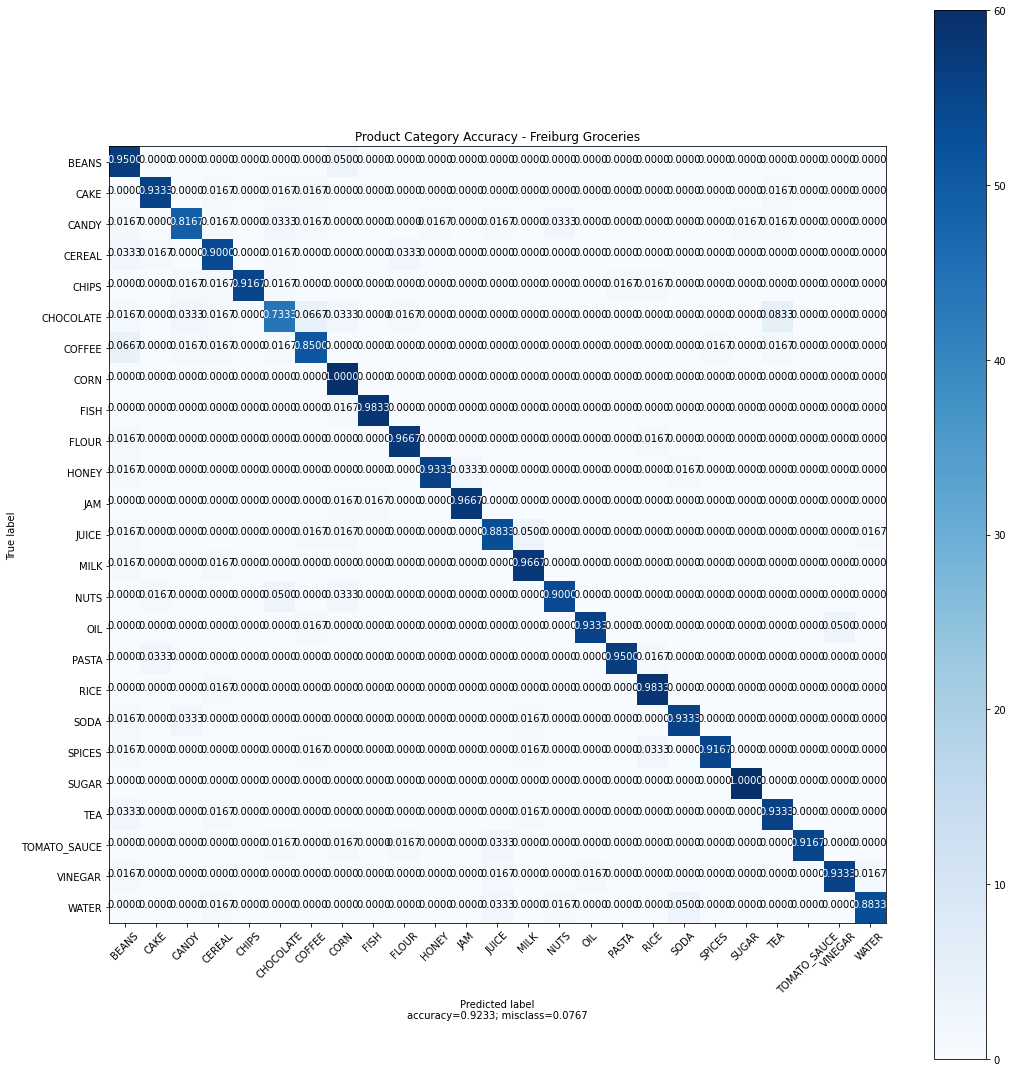

In [ ]:
# generate confusion matrix data
cm = confusion_matrix(y_true=y_test,y_pred=prediction_idxs)
print(cm)

graph_title = 'Product Category Accuracy - ' + dataset_name

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, target_names=class_names, normalize=True, title=graph_title)

plt.show()

In [ ]:
# plot classification report

print(classification_report(y_true=y_test,y_pred=prediction_idxs, target_names=class_names))

              precision    recall  f1-score   support

       BEANS       0.77      0.95      0.85        60
        CAKE       0.93      0.93      0.93        60
       CANDY       0.89      0.82      0.85        60
      CEREAL       0.86      0.90      0.88        60
       CHIPS       1.00      0.92      0.96        60
   CHOCOLATE       0.81      0.73      0.77        60
      COFFEE       0.85      0.85      0.85        60
        CORN       0.85      1.00      0.92        60
        FISH       0.98      0.98      0.98        60
       FLOUR       0.94      0.97      0.95        60
       HONEY       0.98      0.93      0.96        60
         JAM       0.97      0.97      0.97        60
       JUICE       0.90      0.88      0.89        60
        MILK       0.91      0.97      0.94        60
        NUTS       0.95      0.90      0.92        60
         OIL       0.98      0.93      0.96        60
       PASTA       0.98      0.95      0.97        60
        RICE       0.92    

# Train Inception_v3 model

In [ ]:
img_height = 224
img_width = 224
n_classes = 25

# specify location of freiburg groceries dataset, along with train and val folders

model_name = 'Inception-v3'
dataset_name = 'Freiburg Groceries'

root_dir = "/content"
train_dir = "/train"
val_dir = "/val"
test_dir = "/test"


#hyperparameters tuning

In [ ]:
# base network
base_id = 0 # 0 = Inception-v3, 1 = MobileNet, 2 = Inception-ResNet-v2, 3 = ResNet50

# network hyperparameters
n_epochs = 100
n_batches = 32
learning_rate = 0.001
dr = 0.5
wd = 0.0001


# save parameters
date_dir = '2021-10-12' # specify save directory for results using YYYY-MM-DD format
n_rounding = 4
#parameter_type = ' ' # specify parameter (learning_rate, dr, wd) that is being evaluated

In [ ]:
enable_model_save = True
weight_decay_test = True
dropout_test = False
learning_rate_test = False
use_previous_weights = False

# Preprare Training and Validation Data

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, rotation_range=10, horizontal_flip=True)
datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=root_dir+train_dir,target_size=(224,224),
                                                        batch_size=n_batches,shuffle=False)

val_generator = datagen_val_test.flow_from_directory(directory=root_dir+val_dir, target_size=(224, 224),
                                                         batch_size=n_batches, shuffle=False)


Found 7000 images belonging to 25 classes.
Found 1500 images belonging to 25 classes.


In [ ]:

# find y_train/y_val/y_test
y_train = train_generator.classes
y_val = val_generator.classes


    # convert output to one-hot encoding
y_train = np_utils.to_categorical(y=y_train,num_classes=n_classes)
y_val = np_utils.to_categorical(y=y_val, num_classes=n_classes)
n_train = y_train.shape[0]
n_val = y_val.shape[0]



In [ ]:

    # base network = Inception-v3
if base_id is 0:
  base = inception_v3.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (5,5,2048)
  base_name = 'Inception_v3'

    # base network = MobileNet
elif base_id is 1:
  base = mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,1024)
  base_name = 'MobileNet'

    # base network = Inception-ResNet-v2
elif base_id is 2:
  base = inception_resnet_v2.InceptionResNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (5,5,1536)
  base_name = 'Inception_ResNet_v2'

    # base network = ResNet50
elif base_id is 3:
  base = resnet50.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,2048)
  base_name = 'ResNet50'






87924736/87910968 [==============================] - 1s 0us/step


In [ ]:

    # generate features
x_train_features = base.predict(train_generator, steps=n_train/n_batches, verbose=1)
x_val_features = base.predict(val_generator, steps=n_val/n_batches, verbose=1)


    # correct y_train / y_val / y-test lengths
l_train = x_train_features.shape[0]
l_val = x_val_features.shape[0]
y_train = y_train[0:l_train]
y_val = y_val[0:l_val]


 

46/46 [==============================] - 9s 190ms/step


In [ ]:
   # display hyperparameter summary
print("Dataset Summary:")
print ("\tX-Train: "+str(x_train_features.shape[0]))
print ("\tX-Validation: "+str(x_val_features.shape[0]))
print ("\tY-Train: "+str(y_train.shape[0]))
print ("\tY-Validation: "+str(y_val.shape[0]))



Dataset Summary:
	X-Train: 7000
	X-Validation: 1500
	Y-Train: 7000
	Y-Validation: 1500


In [ ]:
    # display hyperparameter summary
print("Hyperparameter Summary:")
print ("\tWeight decay: "+str(wd))
print ("\tDropout: "+str(dr))
print ("\tLearning rate: "+str(learning_rate))
print ("\t# of epochs: "+str(n_epochs))
print ("\tBatch size: "+str(n_batches))



Hyperparameter Summary:
	Weight decay: 0.0001
	Dropout: 0.5
	Learning rate: 0.001
	# of epochs: 100
	Batch size: 32


# Create Model for Training

In [ ]:

    # create dense model on top of base network
model2 = create_dense_model(input_shape=base_output_shape, weight_decay=wd, r_dropout=dr)


    # compile model
model2.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

   

In [ ]:
# create save filenames
if weight_decay_test is True:
  parameter_type = 'wd'
elif dropout_test is True:
  parameter_type = 'dr'
elif learning_rate_test is True:
  parameter_type = 'lr'

file_csv, file_trained_weights = save_filenames(base_name, parameter_type, wd, n_rounding)

In [ ]:
print(x_train_features.shape)

(7000, 5, 5, 2048)


In [ ]:
 # train model

csv_logger = CSVLogger(filename=file_csv, append=True, separator=',')
early_stopper = EarlyStopping(monitor='val_loss', patience=20)
history = model2.fit(x=x_train_features,
                                 y=y_train,
                                 batch_size=n_batches,
                                 epochs=n_epochs,
                                 validation_data=(x_val_features, y_val),
                                 steps_per_epoch=None,
                                 shuffle=True
                                
                                )

Epoch 1/100
219/219 [==============================] - 3s 12ms/step - loss: 2.8056 - accuracy: 0.3449 - val_loss: 1.5859 - val_accuracy: 0.5147
Epoch 2/100
219/219 [==============================] - 2s 11ms/step - loss: 1.3820 - accuracy: 0.5609 - val_loss: 1.4292 - val_accuracy: 0.5573
Epoch 3/100
219/219 [==============================] - 2s 10ms/step - loss: 1.0028 - accuracy: 0.6796 - val_loss: 1.3299 - val_accuracy: 0.6040
Epoch 4/100
219/219 [==============================] - 2s 11ms/step - loss: 0.7413 - accuracy: 0.7624 - val_loss: 1.0564 - val_accuracy: 0.6993
Epoch 5/100
219/219 [==============================] - 2s 11ms/step - loss: 0.5483 - accuracy: 0.8204 - val_loss: 1.2171 - val_accuracy: 0.6553
Epoch 6/100
219/219 [==============================] - 2s 11ms/step - loss: 0.4183 - accuracy: 0.8587 - val_loss: 1.0973 - val_accuracy: 0.7020
Epoch 7/100
219/219 [==============================] - 2s 11ms/step - loss: 0.3352 - accuracy: 0.8901 - val_loss: 1.0333 - val_accuracy:

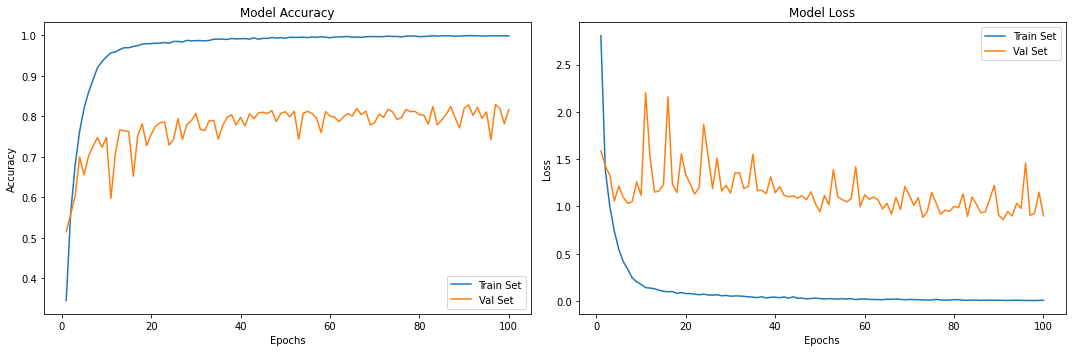

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
if enable_model_save == True:
  model2.save_weights(filepath='/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model2.h5')

In [ ]:
image_datagen = ImageDataGenerator(rescale=1./255)
test_generator = image_datagen.flow_from_directory(directory=root_dir+test_dir,
                                                       target_size=(224,224),
                                                       batch_size=1,
                                                       shuffle=False)
print(test_generator.class_indices)

Found 1500 images belonging to 25 classes.
{'BEANS': 0, 'CAKE': 1, 'CANDY': 2, 'CEREAL': 3, 'CHIPS': 4, 'CHOCOLATE': 5, 'COFFEE': 6, 'CORN': 7, 'FISH': 8, 'FLOUR': 9, 'HONEY': 10, 'JAM': 11, 'JUICE': 12, 'MILK': 13, 'NUTS': 14, 'OIL': 15, 'PASTA': 16, 'RICE': 17, 'SODA': 18, 'SPICES': 19, 'SUGAR': 20, 'TEA': 21, 'TOMATO_SAUCE': 22, 'VINEGAR': 23, 'WATER': 24}


In [ ]:
import collections
od = collections.OrderedDict(sorted(test_generator.class_indices.items(), key=lambda t: t[1]))

# create list of class names
class_names=[]
for name in od:
  class_names.append(name)

# ground truth output
y_test = test_generator.classes

In [ ]:
# create CNN
test_model2 = create_model_test(img_size=(224,224,3),model_type=1,base_name='Inception_v3')

# compile CNN
test_model2.compile(optimizer=RMSprop(learning_rate==learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

Creating InceptionV3 model
Loading weights from /content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model2.h5


In [ ]:
loss, accuracy = test_model2.evaluate(test_generator,
                                              steps=len(test_generator),
                                              max_queue_size=100,
                                              verbose = 1)

print("Test loss:"+str(loss))
print("Test accuracy"+str(accuracy))


    

1500/1500 [==============================] - 55s 34ms/step - loss: 0.9305 - accuracy: 0.8127
Test loss:0.9304623007774353
Test accuracy0.812666654586792


In [ ]:
# predict classes
prediction = test_model2.predict(test_generator,
                                         steps=len(test_generator),
                                         max_queue_size=100,
                                         verbose=1)

np.set_printoptions(precision=3,suppress=True)
prediction = (prediction > 0.5)
prediction_idxs = np.argmax(prediction,axis=1)
print("Predictions-Index Form:"+str(prediction_idxs))



1500/1500 [==============================] - 38s 24ms/step
Predictions-Index Form:[ 0  0  0 ... 12 24 24]


[[58  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0]
 [ 6 49  0  0  1  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0  1  1  0  0
   0]
 [ 2  0 47  1  1  0  1  0  0  1  0  0  0  0  1  0  1  0  0  0  0  3  2  0
   0]
 [ 3  4  1 42  0  3  0  0  2  1  0  0  1  0  0  0  1  1  0  0  0  1  0  0
   0]
 [ 2  0  2  1 47  1  1  0  0  0  0  1  1  0  1  0  2  0  1  0  0  0  0  0
   0]
 [ 3  1  3  3  4 36  1  0  1  0  0  0  1  0  1  0  0  0  2  0  0  3  0  1
   0]
 [ 5  0  0  0  0  2 39  0  0  0  0  2  2  1  1  0  0  2  0  2  2  1  1  0
   0]
 [ 1  0  0  0  0  0  0 58  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
   0]
 [ 1  0  0  0  0  0  0  0 56  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   2]
 [ 0  2  0  0  0  0  0  0  0 54  0  0  0  1  1  0  0  0  1  0  1  0  0  0
   0]
 [ 2  0  0  1  0  1  2  0  0  0 47  4  0  0  0  0  0  0  0  0  0  1  2  0
   0]
 [ 1  1  0  0  0  0  1  1  0  0  0 55  0  0  0  0  0  0  0  1  0  0  0  0
   0]
 [ 1  0  0  0  0  0  0  0  0  0  0  0 48

<Figure size 432x288 with 0 Axes>

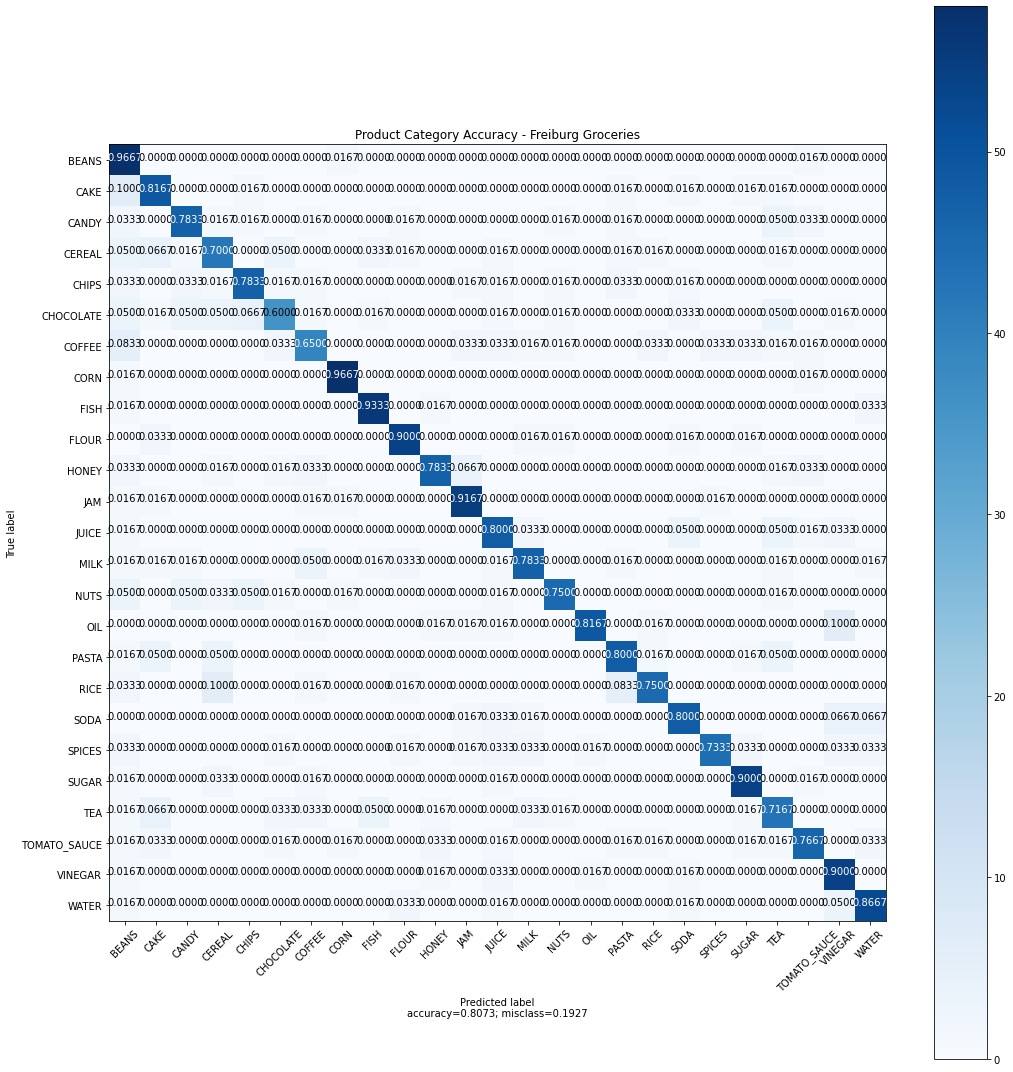

In [ ]:
# generate confusion matrix data
cm = confusion_matrix(y_true=y_test,y_pred=prediction_idxs)
print(cm)

graph_title = 'Product Category Accuracy - ' + dataset_name

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, target_names=class_names, normalize=True, title=graph_title)

plt.show()

In [ ]:
# plot classification report

print(classification_report(y_true=y_test,y_pred=prediction_idxs, target_names=class_names))

              precision    recall  f1-score   support

       BEANS       0.59      0.97      0.73        60
        CAKE       0.73      0.82      0.77        60
       CANDY       0.82      0.78      0.80        60
      CEREAL       0.69      0.70      0.69        60
       CHIPS       0.84      0.78      0.81        60
   CHOCOLATE       0.75      0.60      0.67        60
      COFFEE       0.74      0.65      0.69        60
        CORN       0.94      0.97      0.95        60
        FISH       0.89      0.93      0.91        60
       FLOUR       0.87      0.90      0.89        60
       HONEY       0.89      0.78      0.83        60
         JAM       0.85      0.92      0.88        60
       JUICE       0.74      0.80      0.77        60
        MILK       0.84      0.78      0.81        60
        NUTS       0.88      0.75      0.81        60
         OIL       0.96      0.82      0.88        60
       PASTA       0.80      0.80      0.80        60
        RICE       0.88    

In [ ]:
model2.save("/content/drive/MyDrive/Multi Class Object Classification for Retail Products/saved model/model2.h5")

# Fine tune VGG16

In [ ]:
img_height = 224
img_width = 224
n_classes = 25

# specify location of freiburg groceries dataset, along with train and val folders

model_name = 'vgg16'
dataset_name = 'Freiburg Groceries'

root_dir = "/content"
train_dir = "/train"
val_dir = "/val"
test_dir = "/test"


#hyperparameters tuning

In [ ]:
# base network
base_id = 4 # 0 = Inception-v3, 1 = MobileNet, 2 = Inception-ResNet-v2, 3 = ResNet50 4 = vgg16

# network hyperparameters
n_epochs = 100
n_batches = 32
learning_rate = 0.001
dr = 0.5
wd = 0.0001


# save parameters
date_dir = '2021-10-12' # specify save directory for results using YYYY-MM-DD format
n_rounding = 4
#parameter_type = ' ' # specify parameter (learning_rate, dr, wd) that is being evaluated

In [ ]:
enable_model_save = True
weight_decay_test = True
dropout_test = False
learning_rate_test = False
use_previous_weights = False

# Preprare Training and Validation Data

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, rotation_range=10, horizontal_flip=True)
datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=root_dir+train_dir,target_size=(224,224),
                                                        batch_size=n_batches,shuffle=False)

val_generator = datagen_val_test.flow_from_directory(directory=root_dir+val_dir, target_size=(224, 224),
                                                         batch_size=n_batches, shuffle=False)


Found 7000 images belonging to 25 classes.
Found 1500 images belonging to 25 classes.


In [ ]:

# find y_train/y_val/y_test
y_train = train_generator.classes
y_val = val_generator.classes


    # convert output to one-hot encoding
y_train = np_utils.to_categorical(y=y_train,num_classes=n_classes)
y_val = np_utils.to_categorical(y=y_val, num_classes=n_classes)
n_train = y_train.shape[0]
n_val = y_val.shape[0]



In [ ]:

    # base network = Inception-v3
if base_id is 0:
  base = inception_v3.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (5,5,2048)
  base_name = 'Inception_v3'

    # base network = MobileNet
elif base_id is 1:
  base = mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,1024)
  base_name = 'MobileNet'

    # base network = Inception-ResNet-v2
elif base_id is 2:
  base = inception_resnet_v2.InceptionResNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (5,5,1536)
  base_name = 'Inception_ResNet_v2'

    # base network = ResNet50
elif base_id is 3:
  base = resnet50.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,2048)
  base_name = 'ResNet50'

elif base_id is 4:
  base = vgg16.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,512)
  base_name = 'Vgg16'
 






In [ ]:

    # generate features
x_train_features = base.predict(train_generator, steps=n_train/n_batches, verbose=1)
x_val_features = base.predict(val_generator, steps=n_val/n_batches, verbose=1)

print(x_train_features.shape)
    # correct y_train / y_val / y-test lengths
l_train = x_train_features.shape[0]
l_val = x_val_features.shape[0]
y_train = y_train[0:l_train]
y_val = y_val[0:l_val]


 

46/46 [==============================] - 10s 217ms/step
(7000, 7, 7, 512)


In [ ]:
   # display hyperparameter summary
print("Dataset Summary:")
print ("\tX-Train: "+str(x_train_features.shape[0]))
print ("\tX-Validation: "+str(x_val_features.shape[0]))
print ("\tY-Train: "+str(y_train.shape[0]))
print ("\tY-Validation: "+str(y_val.shape[0]))



Dataset Summary:
	X-Train: 7000
	X-Validation: 1500
	Y-Train: 7000
	Y-Validation: 1500


In [ ]:
    # display hyperparameter summary
print("Hyperparameter Summary:")
print ("\tWeight decay: "+str(wd))
print ("\tDropout: "+str(dr))
print ("\tLearning rate: "+str(learning_rate))
print ("\t# of epochs: "+str(n_epochs))
print ("\tBatch size: "+str(n_batches))



Hyperparameter Summary:
	Weight decay: 0.0001
	Dropout: 0.5
	Learning rate: 0.001
	# of epochs: 100
	Batch size: 32


# Create Model for Training

In [ ]:
def create_dense_model(input_shape,weight_decay, r_dropout):

    input_layer = Input(shape=input_shape)

    top = GlobalAveragePooling2D()(input_layer)
    top = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc_1')(top)

    predictions = Dense(units=n_classes, activation='softmax', kernel_regularizer=l2(l=weight_decay), name='softmax')(top)

    model_combined = Model(inputs=input_layer, outputs=predictions)

    if use_previous_weights is True:
        print("Loading previous weights")
        model_combined.load_weights(filepath='/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model_vgg16.h5', by_name=True) # set path to saved weights here

    return model_combined

In [ ]:
# generate file names for csv and weight files
def save_filenames(base_network_name, test_descriptor, param, precision):

    descriptor = '/' + base_network_name + '_' + test_descriptor + '='

    name_csv = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/results/' + date_dir + descriptor + str(round(param, precision)) + '.csv'
    name_weights = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/' + date_dir + descriptor + str(round(param, precision)) + '.h5'

    return name_csv, name_weights

In [ ]:

    # create dense model on top of base network
model3 = create_dense_model(input_shape=base_output_shape, weight_decay=wd, r_dropout=dr)


    # compile model
model3.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

   

In [ ]:
# create save filenames
if weight_decay_test is True:
  parameter_type = 'wd'
elif dropout_test is True:
  parameter_type = 'dr'
elif learning_rate_test is True:
  parameter_type = 'lr'

file_csv, file_trained_weights = save_filenames(base_name, parameter_type, wd, n_rounding)

In [ ]:
 # train model

csv_logger = CSVLogger(filename=file_csv, append=True, separator=',')
early_stopper = EarlyStopping(monitor='val_loss', patience=20)
history = model3.fit(x=x_train_features,
                                 y=y_train,
                                 batch_size=n_batches,
                                 epochs=n_epochs,
                                 validation_data=(x_val_features, y_val),
                                 steps_per_epoch=None,
                                 shuffle=True
                                
                                )

Epoch 1/100
219/219 [==============================] - 2s 7ms/step - loss: 2.3986 - accuracy: 0.2910 - val_loss: 1.9142 - val_accuracy: 0.4127
Epoch 2/100
219/219 [==============================] - 1s 6ms/step - loss: 1.7086 - accuracy: 0.4870 - val_loss: 1.6723 - val_accuracy: 0.4993
Epoch 3/100
219/219 [==============================] - 1s 6ms/step - loss: 1.4259 - accuracy: 0.5673 - val_loss: 1.4901 - val_accuracy: 0.5453
Epoch 4/100
219/219 [==============================] - 1s 6ms/step - loss: 1.2247 - accuracy: 0.6314 - val_loss: 1.2803 - val_accuracy: 0.6200
Epoch 5/100
219/219 [==============================] - 1s 6ms/step - loss: 1.0693 - accuracy: 0.6686 - val_loss: 1.1790 - val_accuracy: 0.6440
Epoch 6/100
219/219 [==============================] - 1s 6ms/step - loss: 0.9486 - accuracy: 0.7071 - val_loss: 1.3113 - val_accuracy: 0.5867
Epoch 7/100
219/219 [==============================] - 1s 6ms/step - loss: 0.8472 - accuracy: 0.7406 - val_loss: 1.4185 - val_accuracy: 0.5647

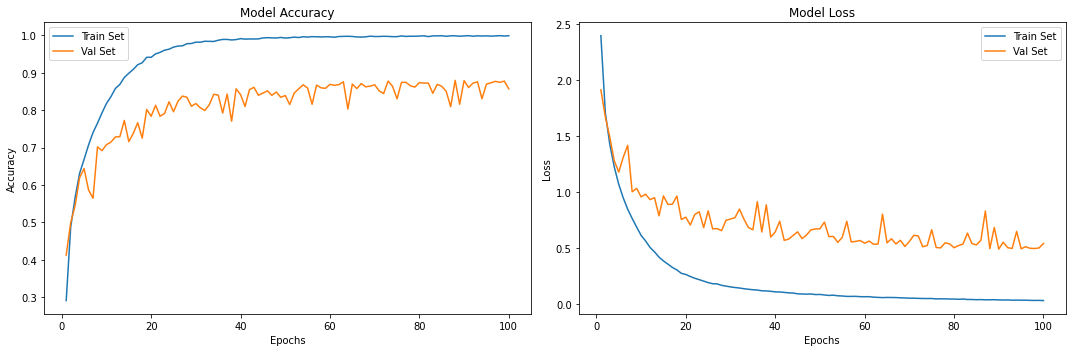

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
if enable_model_save == True:
  model3.save_weights(filepath='/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model_vgg16.h5')
  model3.save('/content/drive/MyDrive/Multi Class Object Classification for Retail Products/saved model/model_vgg16.h5')

In [ ]:
image_datagen = ImageDataGenerator(rescale=1./255)
test_generator = image_datagen.flow_from_directory(directory=root_dir+test_dir,
                                                       target_size=(224,224),
                                                       batch_size=1,
                                                       shuffle=False)
print(test_generator.class_indices)

Found 1500 images belonging to 25 classes.
{'BEANS': 0, 'CAKE': 1, 'CANDY': 2, 'CEREAL': 3, 'CHIPS': 4, 'CHOCOLATE': 5, 'COFFEE': 6, 'CORN': 7, 'FISH': 8, 'FLOUR': 9, 'HONEY': 10, 'JAM': 11, 'JUICE': 12, 'MILK': 13, 'NUTS': 14, 'OIL': 15, 'PASTA': 16, 'RICE': 17, 'SODA': 18, 'SPICES': 19, 'SUGAR': 20, 'TEA': 21, 'TOMATO_SAUCE': 22, 'VINEGAR': 23, 'WATER': 24}


In [ ]:
import collections
od = collections.OrderedDict(sorted(test_generator.class_indices.items(), key=lambda t: t[1]))

# create list of class names
class_names=[]
for name in od:
  class_names.append(name)

# ground truth output
y_test = test_generator.classes

In [ ]:
# create custom model with trained FC layer weights
def create_model_test(img_size,model_type,base_name):

    if model_type == 0:
        print("Creating MobileNet model")
        base = mobilenet.MobileNet(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 1:
        print("Creating InceptionV3 model")
        base = inception_v3.InceptionV3(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 2:
        print("Creating Resnet50 model")
        base = resnet50.ResNet50(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 3:
        print("Creating InceptionResNet-V2 model")
        base = inception_resnet_v2.InceptionResNetV2(input_shape=img_size,include_top=False,weights='imagenet')
    
    elif model_type == 4:
      print("Creating VGG16 model")
      base = vgg16.VGG16(input_shape=img_size,include_top=False,weights='imagenet')


    top = base.output
    top = GlobalAveragePooling2D()(top)

    top = Dense(units=2048,activation='relu',kernel_regularizer=None,name='fc_1')(top)
    predictions = Dense(units=n_classes,activation='softmax',kernel_regularizer=l2(l=wd),name='softmax')(top)

    model_combined = Model(inputs=base.input, outputs=predictions, name=base_name)

    path_to_weights = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model_vgg16.h5' # set path to saved model
    model_combined.load_weights(filepath=path_to_weights,by_name=True)
    print('Loading weights from ' + path_to_weights)

    return model_combined

In [ ]:
# create CNN
test_model3 = create_model_test(img_size=(224,224,3),model_type=4,base_name='vgg16')

# compile CNN
test_model3.compile(optimizer=RMSprop(learning_rate==learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

Creating VGG16 model
Loading weights from /content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model_vgg16.h5


In [ ]:
loss, accuracy = test_model3.evaluate(test_generator,
                                              steps=len(test_generator),
                                              max_queue_size=100,
                                              verbose = 1)

print("Test loss:"+str(loss))
print("Test accuracy"+str(accuracy))


    

1500/1500 [==============================] - 52s 34ms/step - loss: 0.5162 - accuracy: 0.8660
Test loss:0.5161553025245667
Test accuracy0.8659999966621399


In [ ]:
# predict classes
prediction = test_model3.predict(test_generator,
                                         steps=len(test_generator),
                                         max_queue_size=100,
                                         verbose=1)

np.set_printoptions(precision=3,suppress=True)
prediction = (prediction > 0.5)
prediction_idxs = np.argmax(prediction,axis=1)
print("Predictions-Index Form:"+str(prediction_idxs))



1500/1500 [==============================] - 45s 30ms/step
Predictions-Index Form:[ 0  0  0 ... 12 24 24]


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title     A   = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[[55  0  0  1  0  0  0  3  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 2 58  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 6  0 43  1  1  4  0  0  0  0  0  0  0  1  3  0  1  0  0  0  0  0  0  0
   0]
 [ 3  2  1 48  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  3  0  0
   0]
 [ 3  0  1  0 54  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 2  0  1  3  1 51  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0
   0]
 [ 4  0  0  2  1  5 42  0  0  0  3  2  0  1  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0 59  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  0  0  0 59  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 1  0  0  0  0  0  0  1  0 55  1  0  0  2  0  0  0  0  0  0  0  0  0  0
   0]
 [ 0  0  0  0  0  1  0  1  0  0 53  4  0  0  0  0  0  0  0  0  0  0  0  0
   1]
 [ 0  0  0  0  0  1  1  0  0  0  0 58  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [ 5  0  0  0  1  0  0  0  0  0  2  0 44

<Figure size 432x288 with 0 Axes>

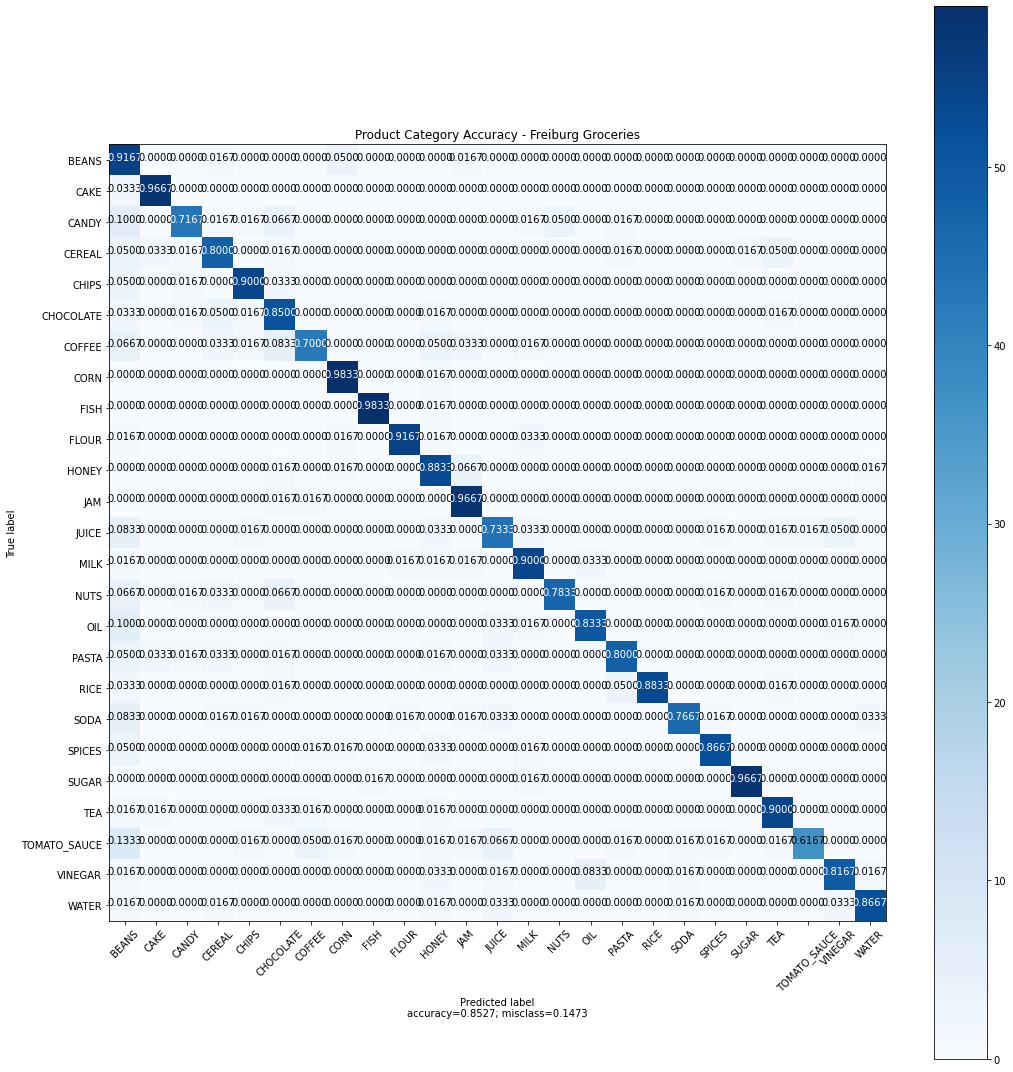

In [ ]:
# generate confusion matrix data
cm = confusion_matrix(y_true=y_test,y_pred=prediction_idxs)
print(cm)

graph_title = 'Product Category Accuracy - ' + dataset_name

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, target_names=class_names, normalize=True, title=graph_title)

plt.show()

In [ ]:
# plot classification report

print(classification_report(y_true=y_test,y_pred=prediction_idxs, target_names=class_names))

              precision    recall  f1-score   support

       BEANS       0.47      0.92      0.62        60
        CAKE       0.92      0.97      0.94        60
       CANDY       0.90      0.72      0.80        60
      CEREAL       0.79      0.80      0.79        60
       CHIPS       0.90      0.90      0.90        60
   CHOCOLATE       0.70      0.85      0.77        60
      COFFEE       0.88      0.70      0.78        60
        CORN       0.89      0.98      0.94        60
        FISH       0.98      0.98      0.98        60
       FLOUR       0.96      0.92      0.94        60
       HONEY       0.75      0.88      0.81        60
         JAM       0.85      0.97      0.91        60
       JUICE       0.77      0.73      0.75        60
        MILK       0.86      0.90      0.88        60
        NUTS       0.94      0.78      0.85        60
         OIL       0.88      0.83      0.85        60
       PASTA       0.89      0.80      0.84        60
        RICE       1.00    

# Fine tune ResNet50

In [ ]:
img_height = 224
img_width = 224
n_classes = 25

# specify location of freiburg groceries dataset, along with train and val folders

model_name = 'ResNet50'
dataset_name = 'Freiburg Groceries'

root_dir = "/content"
train_dir = "/train"
val_dir = "/val"
test_dir = "/test"


#hyperparameters tuning

In [ ]:
# base network
base_id = 3 # 0 = Inception-v3, 1 = MobileNet, 2 = Inception-ResNet-v2, 3 = ResNet50,  4 = vgg16

# network hyperparameters
n_epochs = 100
n_batches = 32
learning_rate = 0.001
dr = 0.5
wd = 0.0001


# save parameters
date_dir = '2021-10-12' # specify save directory for results using YYYY-MM-DD format
n_rounding = 4
#parameter_type = ' ' # specify parameter (learning_rate, dr, wd) that is being evaluated

In [ ]:
enable_model_save = True
weight_decay_test = True
dropout_test = False
learning_rate_test = False
use_previous_weights = False

# Preprare Training and Validation Data

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255, shear_range=0.2, rotation_range=10, horizontal_flip=True)
datagen_val_test = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(directory=root_dir+train_dir,target_size=(224,224),
                                                        batch_size=n_batches,shuffle=False)

val_generator = datagen_val_test.flow_from_directory(directory=root_dir+val_dir, target_size=(224, 224),
                                                         batch_size=n_batches, shuffle=False)


Found 7000 images belonging to 25 classes.
Found 1500 images belonging to 25 classes.


In [ ]:

# find y_train/y_val/y_test
y_train = train_generator.classes
y_val = val_generator.classes


    # convert output to one-hot encoding
y_train = np_utils.to_categorical(y=y_train,num_classes=n_classes)
y_val = np_utils.to_categorical(y=y_val, num_classes=n_classes)
n_train = y_train.shape[0]
n_val = y_val.shape[0]



In [ ]:

    # base network = Inception-v3
if base_id is 0:
  base = inception_v3.InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (5,5,2048)
  base_name = 'Inception_v3'

    # base network = MobileNet
elif base_id is 1:
  base = mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,1024)
  base_name = 'MobileNet'

    # base network = Inception-ResNet-v2
elif base_id is 2:
  base = inception_resnet_v2.InceptionResNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (5,5,1536)
  base_name = 'Inception_ResNet_v2'

    # base network = ResNet50
elif base_id is 3:
  base = resnet50.ResNet50(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,2048)
  base_name = 'ResNet50'

elif base_id is 4:
  base = vgg16.VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
  base_output_shape = (7,7,512)
  base_name = 'Vgg16'
 






94781440/94765736 [==============================] - 1s 0us/step


In [ ]:

    # generate features
x_train_features = base.predict(train_generator, steps=n_train/n_batches, verbose=1)
x_val_features = base.predict(val_generator, steps=n_val/n_batches, verbose=1)

print(x_train_features.shape)
    # correct y_train / y_val / y-test lengths
l_train = x_train_features.shape[0]
l_val = x_val_features.shape[0]
y_train = y_train[0:l_train]
y_val = y_val[0:l_val]


 

46/46 [==============================] - 11s 238ms/step
(7000, 7, 7, 2048)


In [ ]:
   # display hyperparameter summary
print("Dataset Summary:")
print ("\tX-Train: "+str(x_train_features.shape[0]))
print ("\tX-Validation: "+str(x_val_features.shape[0]))
print ("\tY-Train: "+str(y_train.shape[0]))
print ("\tY-Validation: "+str(y_val.shape[0]))



Dataset Summary:
	X-Train: 7000
	X-Validation: 1500
	Y-Train: 7000
	Y-Validation: 1500


In [ ]:
    # display hyperparameter summary
print("Hyperparameter Summary:")
print ("\tWeight decay: "+str(wd))
print ("\tDropout: "+str(dr))
print ("\tLearning rate: "+str(learning_rate))
print ("\t# of epochs: "+str(n_epochs))
print ("\tBatch size: "+str(n_batches))



Hyperparameter Summary:
	Weight decay: 0.0001
	Dropout: 0.5
	Learning rate: 0.001
	# of epochs: 100
	Batch size: 32


# Create Model for Training

In [ ]:
def create_dense_model(input_shape,weight_decay, r_dropout):

    input_layer = Input(shape=input_shape)

    top = GlobalAveragePooling2D()(input_layer)
    top = Dense(units=2048, activation='relu', kernel_regularizer=None, name='fc_1')(top)

    predictions = Dense(units=n_classes, activation='softmax', kernel_regularizer=l2(l=weight_decay), name='softmax')(top)

    model_combined = Model(inputs=input_layer, outputs=predictions)

    if use_previous_weights is True:
        print("Loading previous weights")
        model_combined.load_weights(filepath='/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model_resnet0.h5', by_name=True) # set path to saved weights here

    return model_combined

In [ ]:
# generate file names for csv and weight files
def save_filenames(base_network_name, test_descriptor, param, precision):

    descriptor = '/' + base_network_name + '_' + test_descriptor + '='

    name_csv = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/results/' + date_dir + descriptor + str(round(param, precision)) + '.csv'
    name_weights = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/' + date_dir + descriptor + str(round(param, precision)) + '.h5'

    return name_csv, name_weights

In [ ]:

    # create dense model on top of base network
model4 = create_dense_model(input_shape=base_output_shape, weight_decay=wd, r_dropout=dr)


    # compile model
model4.compile(optimizer=RMSprop(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

   

In [ ]:
# create save filenames
if weight_decay_test is True:
  parameter_type = 'wd'
elif dropout_test is True:
  parameter_type = 'dr'
elif learning_rate_test is True:
  parameter_type = 'lr'

file_csv, file_trained_weights = save_filenames(base_name, parameter_type, wd, n_rounding)

In [ ]:
 # train model

csv_logger = CSVLogger(filename=file_csv, append=True, separator=',')
early_stopper = EarlyStopping(monitor='val_loss', patience=20)
history = model4.fit(x=x_train_features,
                                 y=y_train,
                                 batch_size=n_batches,
                                 epochs=n_epochs,
                                 validation_data=(x_val_features, y_val),
                                 steps_per_epoch=None,
                                 shuffle=True
                                
                                )

Epoch 1/100
219/219 [==============================] - 4s 15ms/step - loss: 3.2729 - accuracy: 0.0579 - val_loss: 3.0869 - val_accuracy: 0.0793
Epoch 2/100
219/219 [==============================] - 3s 13ms/step - loss: 3.0715 - accuracy: 0.0914 - val_loss: 3.0487 - val_accuracy: 0.0840
Epoch 3/100
219/219 [==============================] - 3s 13ms/step - loss: 3.0175 - accuracy: 0.1043 - val_loss: 2.9724 - val_accuracy: 0.1247
Epoch 4/100
219/219 [==============================] - 3s 13ms/step - loss: 2.9714 - accuracy: 0.1156 - val_loss: 2.9885 - val_accuracy: 0.1173
Epoch 5/100
219/219 [==============================] - 3s 13ms/step - loss: 2.9397 - accuracy: 0.1271 - val_loss: 2.9509 - val_accuracy: 0.1260
Epoch 6/100
219/219 [==============================] - 3s 13ms/step - loss: 2.9102 - accuracy: 0.1390 - val_loss: 2.9228 - val_accuracy: 0.1300
Epoch 7/100
219/219 [==============================] - 3s 13ms/step - loss: 2.8904 - accuracy: 0.1440 - val_loss: 2.9368 - val_accuracy:

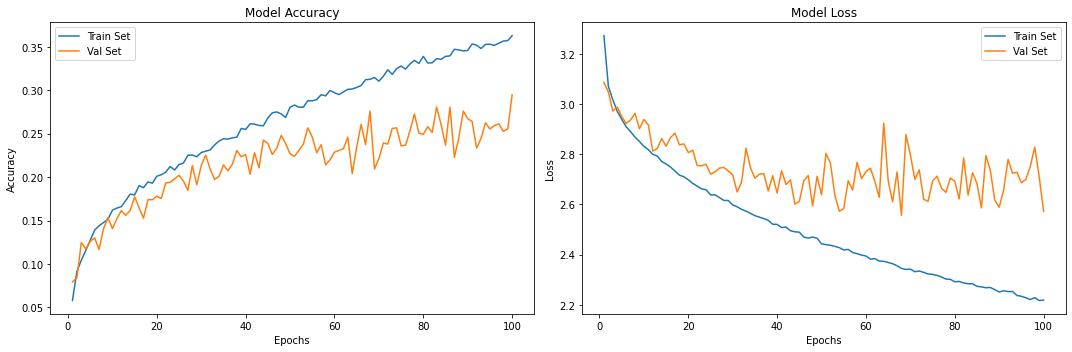

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
if enable_model_save == True:
  model4.save_weights(filepath='/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model_resnet50.h5')
  model4.save('/content/drive/MyDrive/Multi Class Object Classification for Retail Products/saved model/model_resnet50.h5')

In [ ]:
image_datagen = ImageDataGenerator(rescale=1./255)
test_generator = image_datagen.flow_from_directory(directory=root_dir+test_dir,
                                                       target_size=(224,224),
                                                       batch_size=1,
                                                       shuffle=False)
print(test_generator.class_indices)

Found 1500 images belonging to 25 classes.
{'BEANS': 0, 'CAKE': 1, 'CANDY': 2, 'CEREAL': 3, 'CHIPS': 4, 'CHOCOLATE': 5, 'COFFEE': 6, 'CORN': 7, 'FISH': 8, 'FLOUR': 9, 'HONEY': 10, 'JAM': 11, 'JUICE': 12, 'MILK': 13, 'NUTS': 14, 'OIL': 15, 'PASTA': 16, 'RICE': 17, 'SODA': 18, 'SPICES': 19, 'SUGAR': 20, 'TEA': 21, 'TOMATO_SAUCE': 22, 'VINEGAR': 23, 'WATER': 24}


In [ ]:
import collections
od = collections.OrderedDict(sorted(test_generator.class_indices.items(), key=lambda t: t[1]))

# create list of class names
class_names=[]
for name in od:
  class_names.append(name)

# ground truth output
y_test = test_generator.classes

In [ ]:
# create custom model with trained FC layer weights
def create_model_test(img_size,model_type,base_name):

    if model_type == 0:
        print("Creating MobileNet model")
        base = mobilenet.MobileNet(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 1:
        print("Creating InceptionV3 model")
        base = inception_v3.InceptionV3(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 2:
        print("Creating Resnet50 model")
        base = resnet50.ResNet50(input_shape=img_size,include_top=False,weights='imagenet')

    elif model_type == 3:
        print("Creating InceptionResNet-V2 model")
        base = inception_resnet_v2.InceptionResNetV2(input_shape=img_size,include_top=False,weights='imagenet')
    
    elif model_type == 4:
      print("Creating VGG16 model")
      base = vgg16.VGG16(input_shape=img_size,include_top=False,weights='imagenet')


    top = base.output
    top = GlobalAveragePooling2D()(top)

    top = Dense(units=2048,activation='relu',kernel_regularizer=None,name='fc_1')(top)
    predictions = Dense(units=n_classes,activation='softmax',kernel_regularizer=l2(l=wd),name='softmax')(top)

    model_combined = Model(inputs=base.input, outputs=predictions, name=base_name)

    path_to_weights = '/content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model_resnet50.h5' # set path to saved model
    model_combined.load_weights(filepath=path_to_weights,by_name=True)
    print('Loading weights from ' + path_to_weights)

    return model_combined

In [ ]:
# create CNN
test_model4 = create_model_test(img_size=(224,224,3),model_type=2,base_name='ResNet50')

# compile CNN
test_model4.compile(optimizer=RMSprop(learning_rate==learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

Creating Resnet50 model
Loading weights from /content/drive/MyDrive/Multi Class Object Classification for Retail Products/weights/model_resnet50.h5


In [ ]:
loss, accuracy = test_model4.evaluate(test_generator,
                                              steps=len(test_generator),
                                              max_queue_size=100,
                                              verbose = 1)

print("Test loss:"+str(loss))
print("Test accuracy"+str(accuracy))


    

1500/1500 [==============================] - 44s 28ms/step - loss: 2.5407 - accuracy: 0.3107
Test loss:2.5406970977783203
Test accuracy0.31066668033599854


In [ ]:
# predict classes
prediction = test_model4.predict(test_generator,
                                         steps=len(test_generator),
                                         max_queue_size=100,
                                         verbose=1)

np.set_printoptions(precision=3,suppress=True)
prediction = (prediction > 0.5)
prediction_idxs = np.argmax(prediction,axis=1)
print("Predictions-Index Form:"+str(prediction_idxs))



1500/1500 [==============================] - 31s 20ms/step
Predictions-Index Form:[ 0  0  0 ...  0  0 18]


In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title     A   = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

[[57  0  0  0  0  0  0  0  1  1  0  0  0  0  0  1  0  0  0  0  0  0  0  0
   0]
 [51  0  7  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
   0]
 [27  0 28  1  1  2  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
   0]
 [48  0  2  2  1  2  0  0  0  1  0  0  0  1  0  0  0  0  0  0  3  0  0  0
   0]
 [44  0  7  0  8  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [43  0  1  0  0 12  1  0  0  1  0  0  1  0  0  0  0  0  0  0  0  1  0  0
   0]
 [47  0  1  0  0  4  5  0  0  0  0  1  1  0  0  0  0  0  1  0  0  0  0  0
   0]
 [54  0  0  0  0  0  0  4  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [44  0  1  0  0  2  0  1 12  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]
 [54  0  0  0  0  0  0  0  0  3  0  0  0  0  1  0  0  0  0  2  0  0  0  0
   0]
 [56  0  0  0  0  0  1  0  0  0  0  1  0  1  0  0  0  0  0  1  0  0  0  0
   0]
 [29  0  0  0  0  3  0  0  0  1  0 21  0  0  0  1  0  0  0  0  0  0  0  5
   0]
 [48  0  1  0  0  0  0  0  0  1  0  0  7

<Figure size 432x288 with 0 Axes>

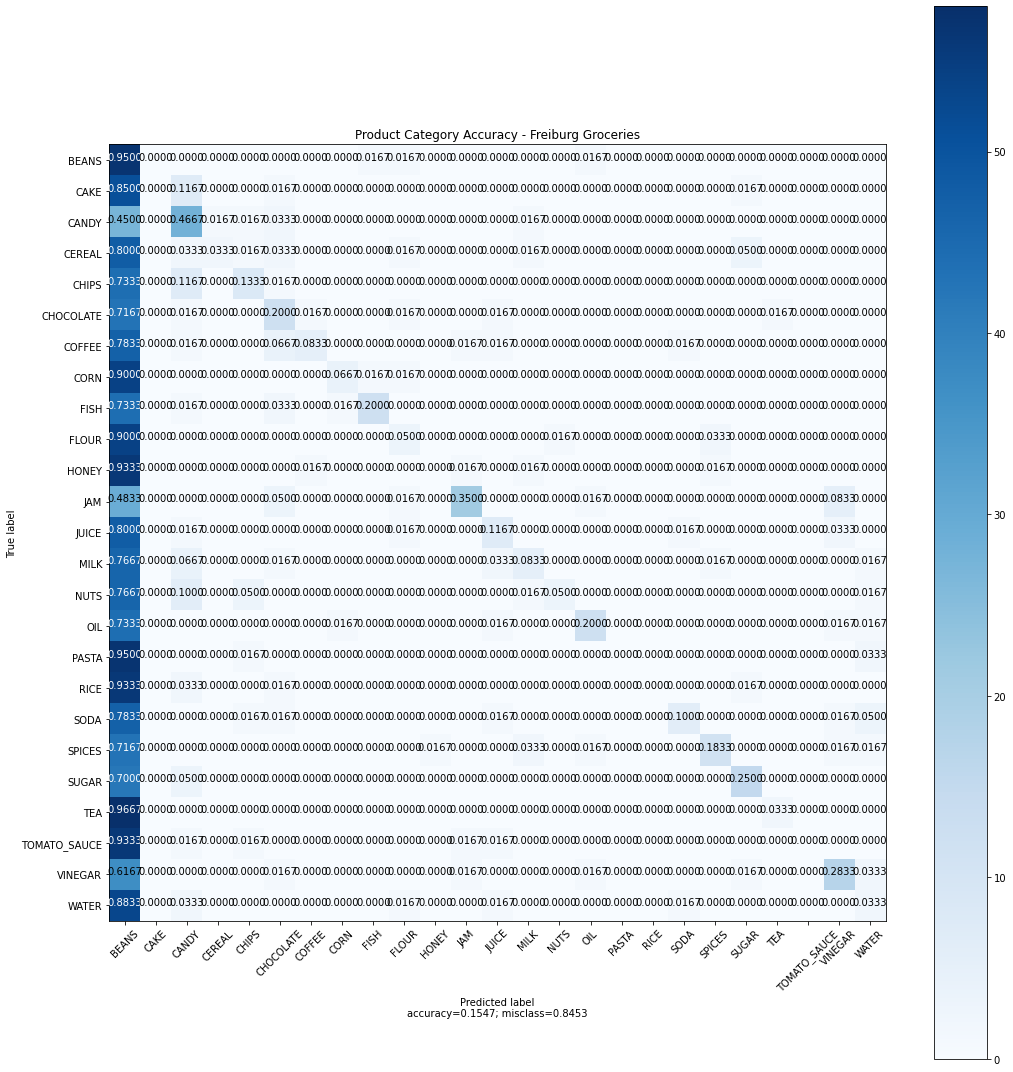

In [ ]:
# generate confusion matrix data
cm = confusion_matrix(y_true=y_test,y_pred=prediction_idxs)
print(cm)

graph_title = 'Product Category Accuracy - ' + dataset_name

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, target_names=class_names, normalize=True, title=graph_title)

plt.show()

In [ ]:
# plot classification report

print(classification_report(y_true=y_test,y_pred=prediction_idxs, target_names=class_names))

              precision    recall  f1-score   support

       BEANS       0.05      0.95      0.09        60
        CAKE       0.00      0.00      0.00        60
       CANDY       0.42      0.47      0.44        60
      CEREAL       0.67      0.03      0.06        60
       CHIPS       0.50      0.13      0.21        60
   CHOCOLATE       0.39      0.20      0.26        60
      COFFEE       0.71      0.08      0.15        60
        CORN       0.67      0.07      0.12        60
        FISH       0.86      0.20      0.32        60
       FLOUR       0.30      0.05      0.09        60
       HONEY       0.00      0.00      0.00        60
         JAM       0.84      0.35      0.49        60
       JUICE       0.47      0.12      0.19        60
        MILK       0.45      0.08      0.14        60
        NUTS       0.75      0.05      0.09        60
         OIL       0.75      0.20      0.32        60
       PASTA       0.00      0.00      0.00        60
        RICE       0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
